# DHSI Day 3 - Part 2

## Outline

We will demonstrate how to add Optical Character Recognition (OCR) to Spark workflow, using the commonly used OCR tool tesseract and its Python wrapper pytesseract.

## Preliminaries - getting the data

The data packages includes OCR data for the year 1916, and page images for the months of July, August and September.

To get all this data and unpack it you will need 5GB of space.  To check how much you have, run:

    df -h
    
You need to have more than 5G in the "Avail" column for entry /dev/vda1  If you don't have enough space, let the instructors know.

    scp ubuntu@192.168.169.14:/home/ubuntu/dhsi_day3_pm.tar.gz .
    tar xvfz dhsi_day3_pm.tar.gz
    cd dhsi_day3_pm
    hdfs dfs -mkdir /dhsi_day3_pm
    hdfs dfs -put *.png /dhsi_day3_pm
    hdfs dfs -put *.xml /dhsi_day3_pm

In [ ]:
! scp ubuntu@
! tar xvfz dhsi_day3_pm.tar.gz
! cd dhsi_day3_pm
! hdfs dfs -mkdir /dhsi_day3_pm
! hdfs dfs -put *.png /dhsi_day3_pm
! hdfs dfs -put *.xml /dhsi_day3_pm

## OCR with Tesseract

### Direct use of Tesseract

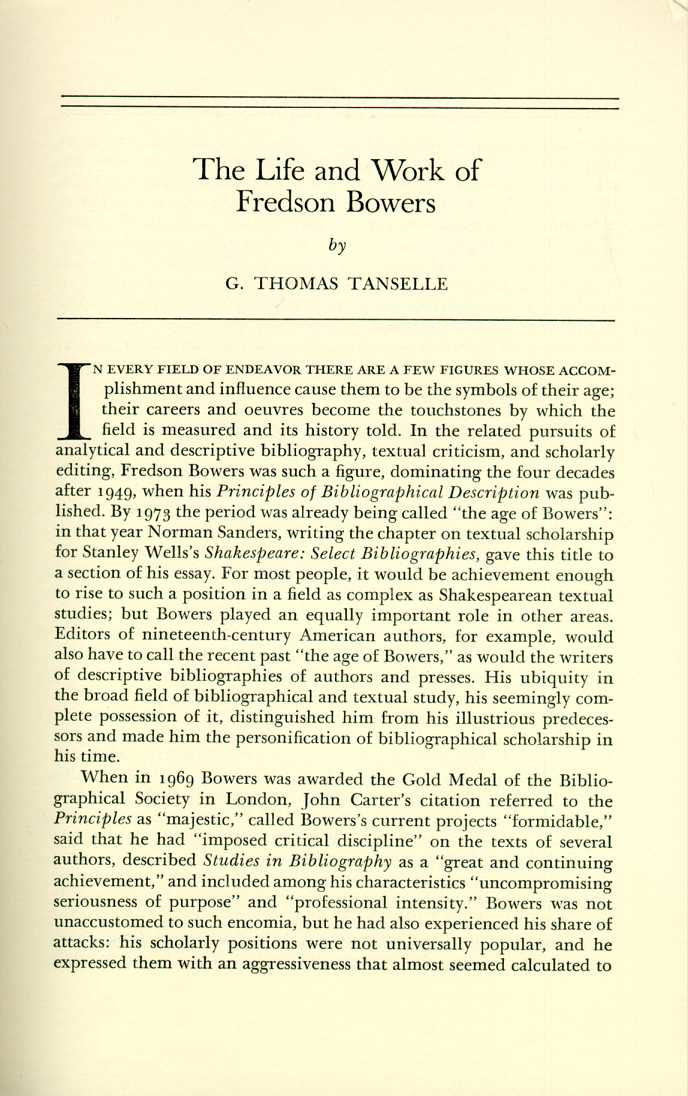

In [1]:
from IPython.display import Image as Img
Img(filename='sample_text.png')

In [3]:
! tesseract sample_text.png stdout

 

 

The Life and Work of
Fredson Bowers

by
G. THOMAS TANSELLE

 

N rvesr new or cunravoa rum are a raw rrnuecs wnosc Accolvl»
plishinenr and inﬂuence cause them to bc rhe symbols oi rheir age;
iheir careers and oeuvres become the tullchstunes by which lhe
ﬁeld is measured and iLs hisiory sold. in she related pursuils oi

analyrical and descripiive bibliography, textual crilirism, and scholarly
ediring. Frcdson Bowers was such a ﬁglu'c. dominaung rhe four decades
aher i949, when his Principlz: of Bibliogmphilrzll Descripnoa was pub-
lished. By X973 she period was already lacing called “die age ol Bowers”:
in char year Norman Sanders, wriiing the chaprer on Lexlnal scholarship
for Sranley Wells's Shllhe'symre: Select Bioliographier, gave rhis ride lo
a secrion of his essay. For rnosi people. is would he achieverneni enough
to rise to such a posirion in a iield as complex as Shakespearean textual
surdies; but Bowers played an equally imporram role in olher areas.
Edirors oi ninereenih

In [6]:
! tesseract sample_text.png output
! head output.txt

Tesseract Open Source OCR Engine v3.03 with Leptonica
 

 

The Life and Work of
Fredson Bowers

by
G. THOMAS TANSELLE



### Use tesseract in Python with pytesseract

In [5]:
import pytesseract
import Image
im=Image.open('sample_text.png')
resultOCR=pytesseract.image_to_string(im)

print(resultOCR)


The Life and Work of
Fredson Bowers

by
G. THOMAS TANSELLE

 

N rvesr new or cunravoa rum are a raw rrnuecs wnosc Accolvl»
plishinenr and inﬂuence cause them to bc rhe symbols oi rheir age;
iheir careers and oeuvres become the tullchstunes by which lhe
ﬁeld is measured and iLs hisiory sold. in she related pursuils oi

analyrical and descripiive bibliography, textual crilirism, and scholarly
ediring. Frcdson Bowers was such a ﬁglu'c. dominaung rhe four decades
aher i949, when his Principlz: of Bibliogmphilrzll Descripnoa was pub-
lished. By X973 she period was already lacing called “die age ol Bowers”:
in char year Norman Sanders, wriiing the chaprer on Lexlnal scholarship
for Sranley Wells's Shllhe'symre: Select Bioliographier, gave rhis ride lo
a secrion of his essay. For rnosi people. is would he achieverneni enough
to rise to such a posirion in a iield as complex as Shakespearean textual
surdies; but Bowers played an equally imporram role in olher areas.
Edirors oi ninereenihcernur

## Beautiful Soup - tool for parsing xml files

In [5]:
from bs4 import BeautifulSoup

#f=open("shorter_example")
#soup = BeautifulSoup(f,"lxml")
#f.close()

html_doc = """
<html><head><title>The Dormouse's story</title></head>
<body>
<p class="title"><b>The Dormouse's story</b></p>

<p class="story">Once upon a time there were three little sisters; and their names were
<a href="http://example.com/elsie" class="sister" id="link1">Elsie</a>,
<a href="http://example.com/lacie" class="sister" id="link2">Lacie</a> and
<a href="http://example.com/tillie" class="sister" id="link3">Tillie</a>;
and they lived at the bottom of a well.</p>

<p class="story">...</p>
"""

soup = BeautifulSoup(html_doc,"lxml")

print(soup.prettify())


<html>
 <head>
  <title>
   The Dormouse's story
  </title>
 </head>
 <body>
  <p class="title">
   <b>
    The Dormouse's story
   </b>
  </p>
  <p class="story">
   Once upon a time there were three little sisters; and their names were
   <a class="sister" href="http://example.com/elsie" id="link1">
    Elsie
   </a>
   ,
   <a class="sister" href="http://example.com/lacie" id="link2">
    Lacie
   </a>
   and
   <a class="sister" href="http://example.com/tillie" id="link3">
    Tillie
   </a>
   ;
and they lived at the bottom of a well.
  </p>
  <p class="story">
   ...
  </p>
 </body>
</html>


In [13]:
taglist = soup.find_all("a")

print("\n print whole tags <\a>")
for tag in taglist:
    print(tag)

print("\n strings in tags <a> \n")
for tag in taglist:
    print(tag.string)

print("\n class  of tag <a> \n")
for tag in taglist:
    print(tag["class"])
    


 print whole tags <>
<a class="sister" href="http://example.com/elsie" id="link1">Elsie</a>
<a class="sister" href="http://example.com/lacie" id="link2">Lacie</a>
<a class="sister" href="http://example.com/tillie" id="link3">Tillie</a>

 strings in tags <a> 

Elsie
Lacie
Tillie

 class  of tag <a> 

['sister']
['sister']
['sister']


In [21]:
headtags = soup.find_all("head")

print(headtags)

titletag = headtag[0].find_all("title")

print(titletag)

[<head><title>The Dormouse's story</title></head>]
[<title>The Dormouse's story</title>]


## Activity - search for term in Gale Cengage data

This year it is the 100th anniversary of the Battle of the Somme, which started on July 1st and lasted into late 1916.  [( see Wikipedia link)](https://en.wikipedia.org/wiki/Battle_of_the_Somme "link")  

We want to examine how frequently the word "Somme" occurs in The Times in the course of 1916.

### Example scan of page from September 29, 1916

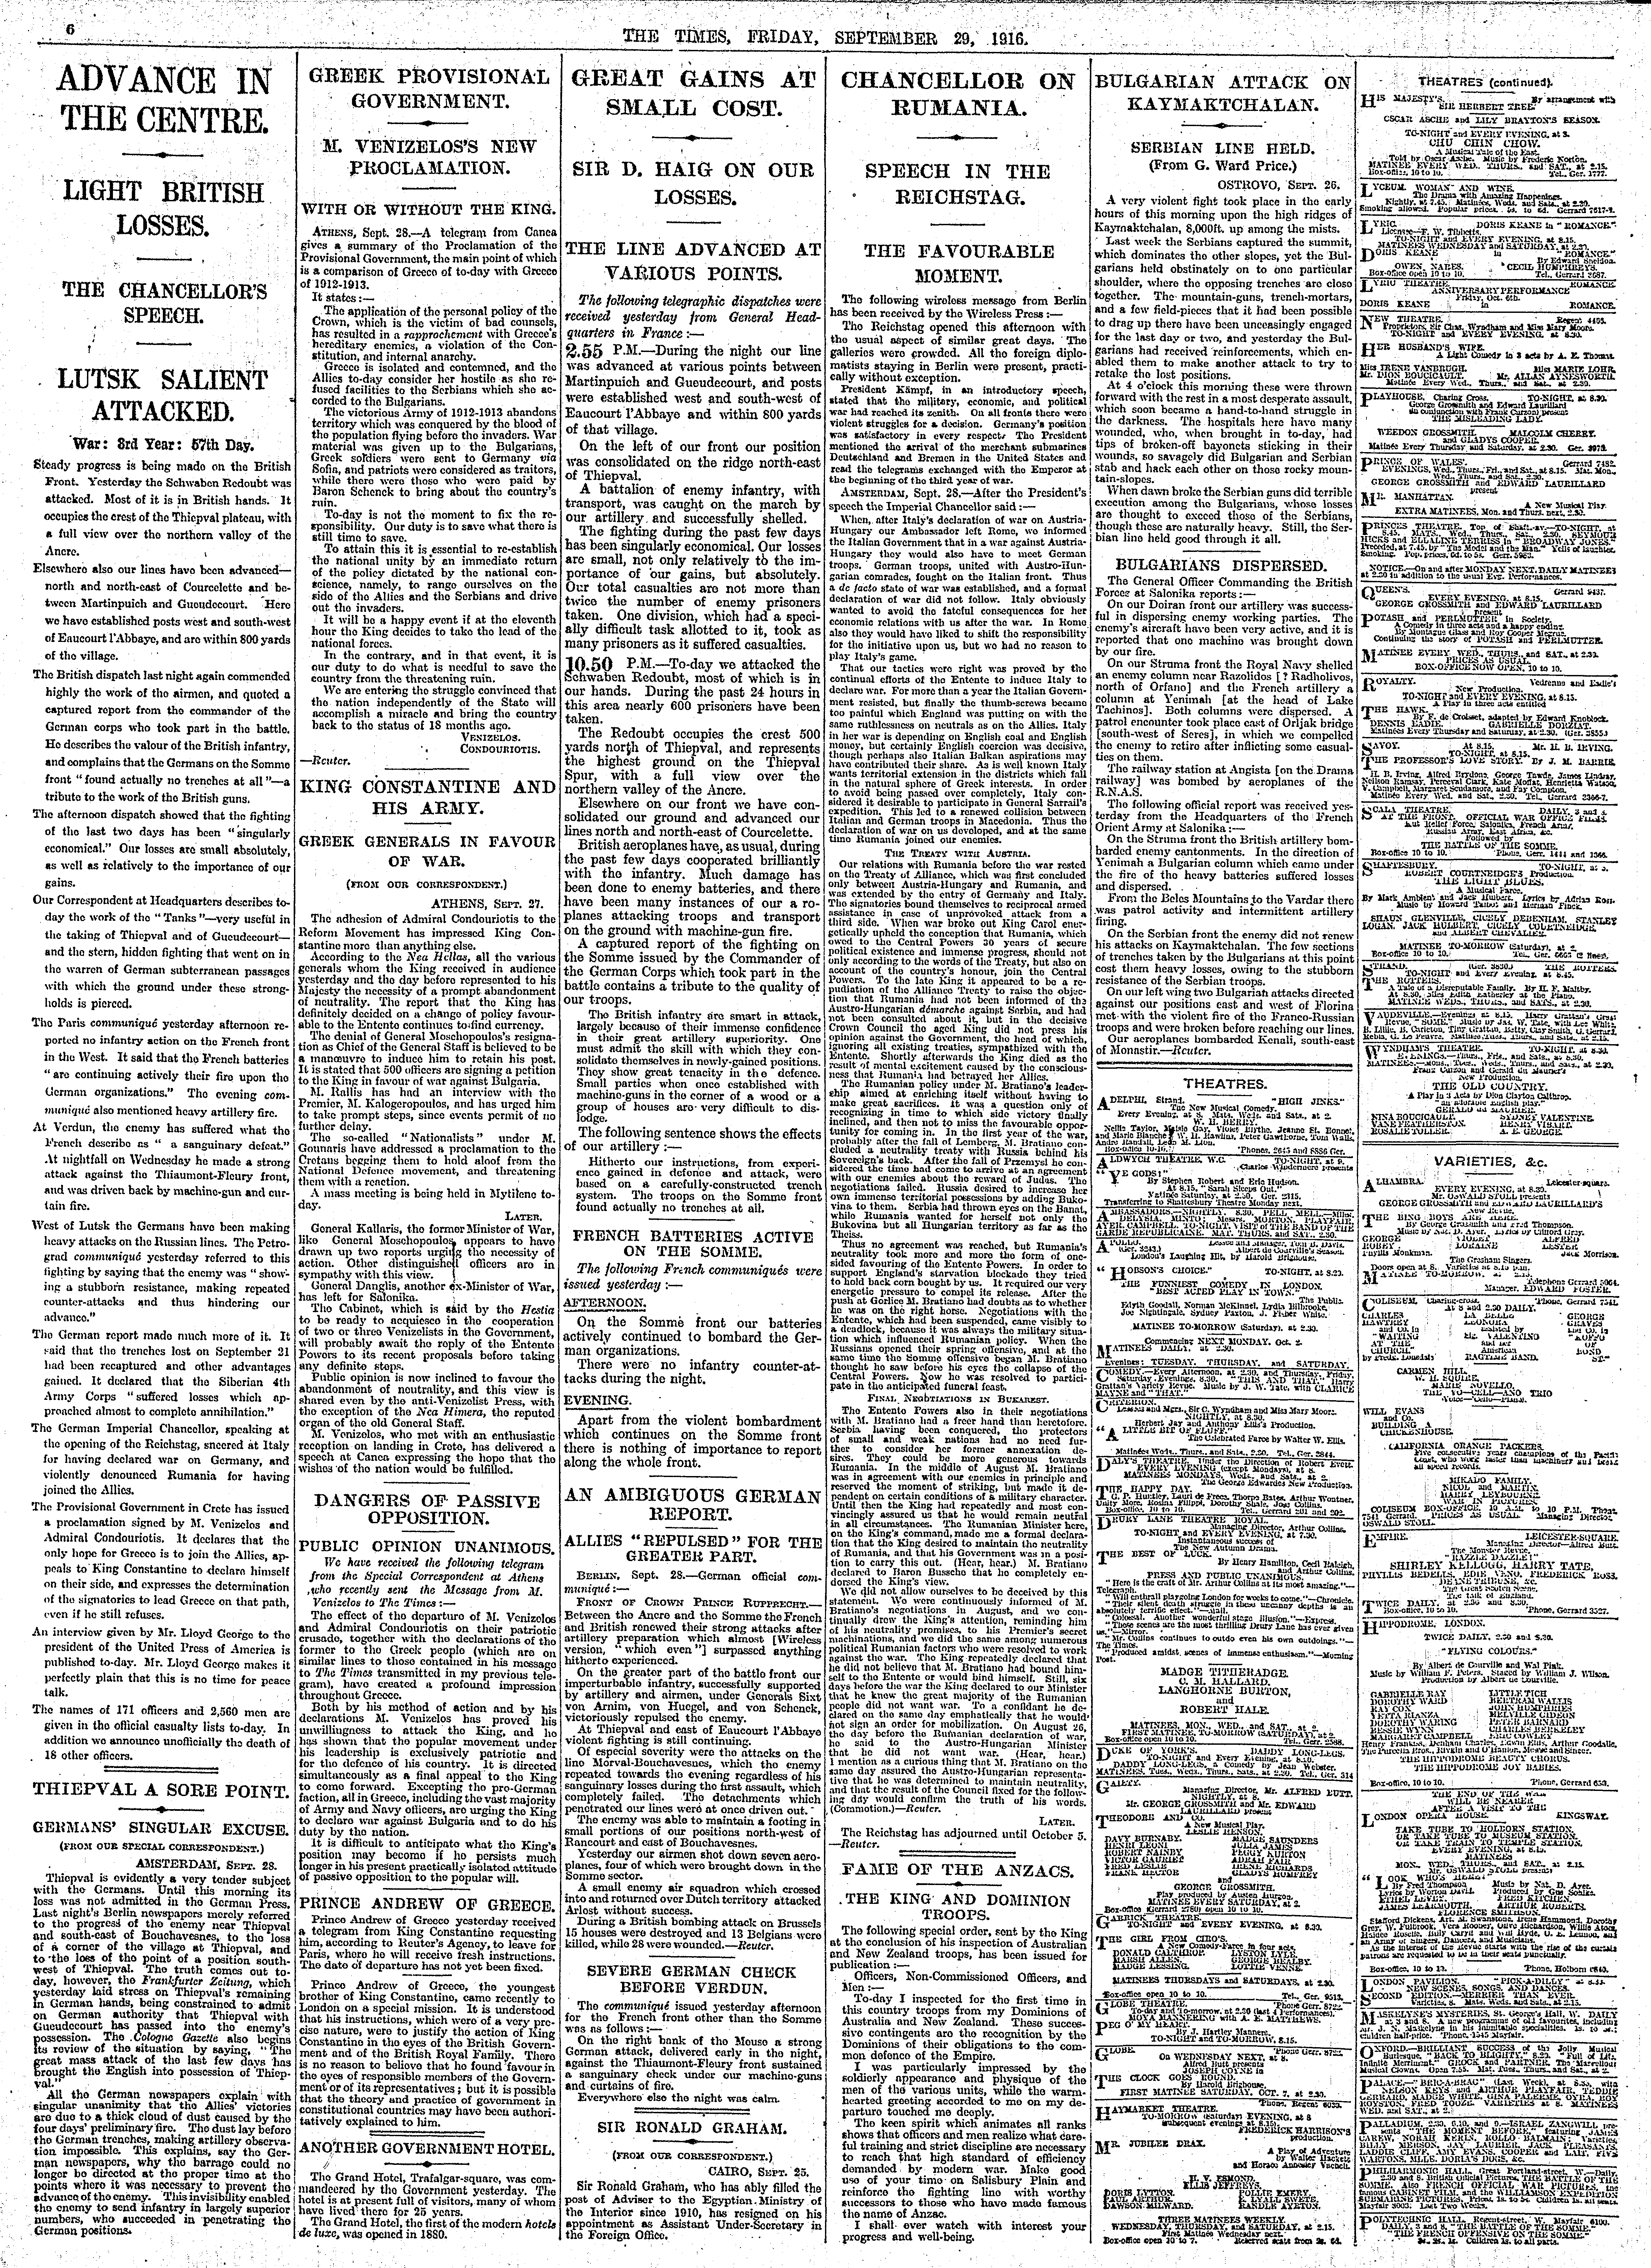

In [4]:
from IPython.display import Image as Img
Img(filename='0FFO-1916-SEP29-006.png')

## Scan for occurences of search term - make histogram of data

In [30]:
import findspark
import os
findspark.init()

import pyspark
sc = pyspark.SparkContext()

In [83]:
from bs4 import BeautifulSoup
import Image
from cStringIO import StringIO
import pytesseract

def count_in_file_spark(something):
    
    filename=something[0]
    f=something[1]
    
    count=f.count(searchterm)

    return (filename,count)

xmlfiles=sc.wholeTextFiles('hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916*.xml')

output=xmlfiles.map(count_in_file_spark)

output_list=output.collect()
print("list generated")
print(output_list)


list generated
[(u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR01.xml', 1), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR03.xml', 2), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR04.xml', 0), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR05.xml', 0), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR06.xml', 0), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR07.xml', 0), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR08.xml', 0), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR10.xml', 0), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR11.xml', 1), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR12.xml', 0), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR13.xml', 1), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR14.xml', 0), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR15.xml', 0), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR17.xml', 4), (u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-APR18.xml', 0), (u'hdfs://localhost:9000

## Plotting dates in Python

In [82]:
#for d in output_list:
    #print(d[0][-9:-4],d[1])


In [81]:
import datetime
list_of_months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]

list_of_dates_plus_count=[]
for d in output_list:
    month_c=d[0][-9:-6]
    day=int(d[0][-6:-4])
    month_i=list_of_months.index(month_c)+1
  #  print(month_c,month_i,day)
    list_of_dates_plus_count.append([datetime.date(1916,month_i,day),d[1]])
    
#print(list_of_dates_plus_count)

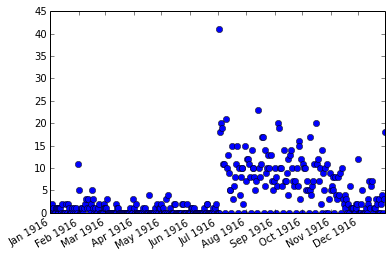

In [80]:
import matplotlib.pyplot as plt
from matplotlib.dates import drange
from numpy import arange,zeros
%matplotlib inline

date1 = datetime.datetime(1916, 1, 1)
date2 = datetime.datetime(1916, 12, 31)
delta = datetime.timedelta(days=1)
dates = drange(date1, date2, delta)
data = zeros(len(dates))

for ele in list_of_dates_plus_count:
    data[ele[0].toordinal()-date1.toordinal()]=ele[1]
    
fig, ax = plt.subplots()
ax.plot_date(dates, data)

#ax.fmt_xdata = DateFormatter('%Y-%m-%d %H:%M:%S')
fig.autofmt_xdate()

plt.show()


## Improving our results with OCR

The quality of the above graph will depend on the quality of the Optical Character Recognition (OCR) done to obtain the text.  We can compare original OCR and what we get by running the image through tesseract.

    time tesseract 0FFO-1916-SEP29-006.png 0FFO-1916-SEP29-006
    Tesseract Open Source OCR Engine v3.03 with Leptonica

    real    9m55.593s
    user    9m53.935s
    sys    0m0.315s

    grep Somme 0FFO-1916-SEP29-006.txt | wc -l
    9

    grep Somme 0FFO-1916-SEP29.xml |wc -l
    3
    
The numbers indicate that the GaleCengage scans missed a significant fraction (possibly 2/3) of the occurences of the word Somme in the text.

There are 4773 page scans for the year 1916, so running all of them through tesseract on a single machine, assuming one page takes 10 minutes to process, would require 47730 minutes, or 33 days of computation.

If we don't have the resources to do that kind of work in a reasonable amount of time, we could partially improve the results by taking the articles in which the word "Somme" was found by GaleCengage OCR and rescanning only those articles to see if there are more occurences.

In [25]:
from bs4 import BeautifulSoup
import Image
from cStringIO import StringIO
import pytesseract

def process_file(f):
    
    output_list=[]
    
    soup = BeautifulSoup(f,"lxml")
    taglist = soup.find_all("text")
    
    for tagtxt in taglist: 
        pageinfo=tagtxt.find_all("pg")
        
# check if search term occurs in text tag
        termfound=False
        words=tagtxt.find_all("wd")
        for w in words:
            if(w.string == searchterm):
                termfound=True
                print("FOUND")

# if yes, scan the text in tag
        if(termfound==True):
            for p in pageinfo:
                textbox=p["pos"].split(",")
                textbox=map(int,textbox) # convert 4 strings to 4 integers
                pagenumber=p["pgref"]
                imagefile=f.name.strip(".xml")+"-"+pagenumber.zfill(3)+".png"
                im = Image.open(imagefile)
                im_cropped = im.crop(textbox)  

                im_cropped.save("image_for_ocr.png")
                textOCR = pytesseract.image_to_string(im_cropped)
                print(textOCR)
                print(imagefile,textbox)
                print(textOCR.count(searchterm))
                output_list.append([imagefile,textbox ])
            
    return output_list


searchterm = "Somme"
f=open("0FFO-1916-SEP29.xml")
output_list=process_file(f)
f.close()
print(output_list)

FOUND
FOUND
FOUND
GREAT’GAI‘NS ALT
SMALL“ COST. ‘ 1
. ‘ , . 1
l

sin D. HAIG ON " OUR {
LOSSES.

 

THE LINE ADVANCED ,AT‘
VARIOUS POINTS. 1
('0FFO-1916-SEP29-006.png', [1663, 149, 2446, 851])
0
The [aliasing telegraphic dispatches were
received yesterday from General Head-
quarters in France 2—- _' '
2,55 P.M.—-During the night out line
Was advanced at various points between
Martinpuich and Gueudecourt, and posts
were established west and south-west of
Eaucourt'l’Abbayo and Within 800 yards

of that village.

0n the left of our front our position
was consolidated on the ridge north-east
of Thiepval. .

A battalion of enemy infantry, with
transport, was caught on the patch by‘
our artillery, and successftu shelled.

The ﬁghting during the past few days
has been singularly economical. Our losses
are small, not only relatively tb the im-
portance of 'our gains, but absolutely.
Our total casualties are not more than
twice the number of enemy prisoners
taken. One division, which had a. s c

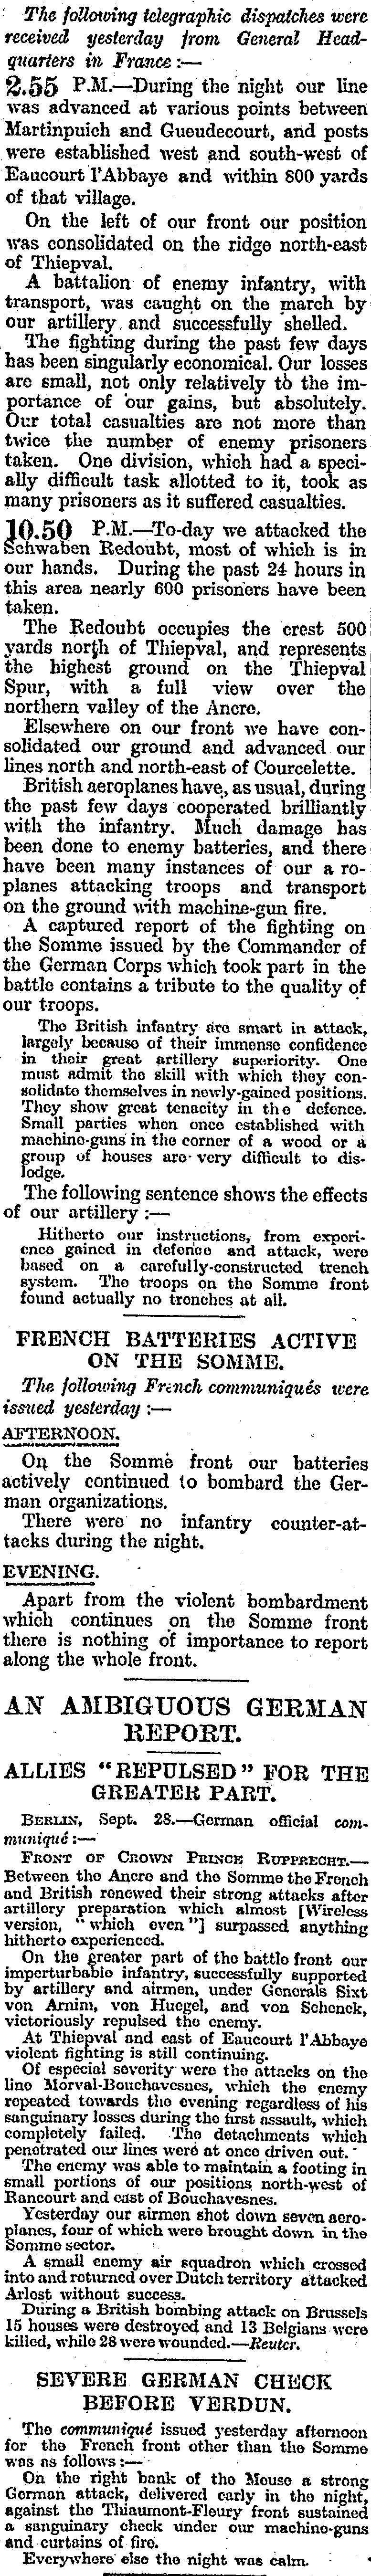

In [26]:
from IPython.display import Image as Img
Img(filename='image_for_ocr.png')


In [10]:
from bs4 import BeautifulSoup
import Image
from cStringIO import StringIO
import pytesseract

def process_file(f):
    
    output_list=[]
    
    soup = BeautifulSoup(f,"lxml")
    taglist = soup.find_all("text")
    
    for tagtxt in taglist: 
        pageinfo=tagtxt.find_all("pg")
        
# check if search term occurs in text tag
        termfound=False
        words=tagtxt.find_all("wd")
        for w in words:
            if(w.string == searchterm):
                termfound=True
                print("FOUND")

        if(termfound==True):
            for p in pageinfo:
                textbox=p["pos"].split(",")
                textbox=map(int,textbox) # convert 4 strings to 4 integers
                pagenumber=p["pgref"]
                imagefile=f.name.strip(".xml")+"-"+pagenumber.zfill(3)+".png"
                output_list.append([imagefile,textbox ])
            
    return output_list

def process_image_file(fim):
    
    list_of_boxes=[]
    for element in output_list:
        if element[0]==fim.name:
            list_of_boxes.append(element[1])
    
    totalfound=0
    if( len(list_of_boxes)>0 ):
        im = Image.open(fim)
        
        for box in list_of_boxes:
            im_cropped = im.crop(box)
            textOCR = pytesseract.image_to_string(im_cropped)
            totalfound=totalfound+textOCR.count("Somme")
            
    return totalfound
            
searchterm = "Somme"
f=open("0FFO-1916-SEP29.xml")
output_list=process_file(f)
f.close()
print(output_list)


file_image=open("0FFO-1916-SEP29-006.png","r")
result=process_image_file(file_image)
file_image.close()

print("total found is ",result)


FOUND
FOUND
FOUND
[['0FFO-1916-SEP29-006.png', [1663, 149, 2446, 851]], ['0FFO-1916-SEP29-006.png', [1666, 860, 2443, 6257]]]
('total found is ', 7)


In [1]:
import findspark
import os
findspark.init()

import pyspark
sc = pyspark.SparkContext()

In [2]:
from bs4 import BeautifulSoup
import Image
from cStringIO import StringIO
import pytesseract

def process_file_spark(something):
    
    filename=something[0]
    f=something[1]
    output_list=[]
    
    soup = BeautifulSoup(f,"lxml")
    taglist = soup.find_all("text")
    
    for tagtxt in taglist: 
        pageinfo=tagtxt.find_all("pg")
        
# check if search term occurs in text tag
        termfound=False
        words=tagtxt.find_all("wd")
        for w in words:
            if(w.string == searchterm):
                termfound=True
                print("FOUND")

        if(termfound==True):
            for p in pageinfo:
                textbox=p["pos"].split(",")
                textbox=map(int,textbox) # convert 4 strings to 4 integers
                pagenumber=p["pgref"]
                imagefile=filename.strip(".xml")+"-"+pagenumber.zfill(3)+".png"
                output_list.append([imagefile,textbox ])
            
    return output_list

def process_image_file_spark(something):
    
    filename=something[0]
    list_of_boxes=[]
    for element in output_list:
        for element1 in element:
            if element1[0]==filename:
                list_of_boxes.append(element1[1])
    
    totalfound=0

    if( len(list_of_boxes)>0 ):
        image_data=StringIO(something[1])
        im=Image.open(image_data)
        
        for box in list_of_boxes:
            im_cropped = im.crop(box)
            textOCR = pytesseract.image_to_string(im_cropped)
            totalfound=totalfound+textOCR.count(searchterm)
    return totalfound

searchterm = "Somme"

#xmlfiles=sc.wholeTextFiles('hdfs://hdp:9000/pawel/day3/0F*xml')
#xmlfiles=sc.wholeTextFiles('hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP29.xml')
xmlfiles=sc.wholeTextFiles('hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP2*.xml')

xmlfiles.cache()
output=xmlfiles.map(process_file_spark)

output_list=output.collect()
print("outside",output_list)

#imgfiles=sc.binaryFiles('hdfs://hdp:9000/pawel/day3/0F*jpg')
#imgfiles=sc.binaryFiles('hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP29-006.png')
#imgfiles=sc.binaryFiles('hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP2*.png')

print("XXXXXXXXXXX")

files=[]
for o in output_list:
    for o1 in o:
        files.append(o1[0])

#files=["hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP25-008.png","hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP20-008.png"]

files=list(set(files))
#print(files)
for f in files:
    print(f)
    
# need to remove duplicates in list
print("XXXXXXXXXXX")
imgfiles=sc.binaryFiles(','.join(files))
imgfiles.cache()

globalcount = imgfiles.map(process_image_file_spark)

print("global count is ",globalcount.collect())

('outside', [[[u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP20-007.png', [4043, 180, 4873, 807]], [u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP20-007.png', [4043, 810, 4863, 6713]], [u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP20-008.png', [1670, 153, 2453, 747]], [u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP20-008.png', [1670, 753, 2447, 3087]], [u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP20-008.png', [1670, 3093, 2450, 3470]], [u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP20-008.png', [1670, 3473, 2450, 5983]], [u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP20-008.png', [2463, 4630, 3240, 4917]], [u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP20-008.png', [2453, 4920, 3240, 6713]]], [[u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP21-008.png', [880, 151, 1654, 809]], [u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP21-008.png', [883, 811, 1651, 6660]]], [[u'hdfs://localhost:9000/dhsi_day3_pm/0FFO-1916-SEP22-006.png', [1666, 151, 2449, 7